# **Deep Learning Methods for Facial Emotion Recognition**

# **Transfer Learning using the VGG16 model**
----

# **Brief Overview**

This notebook is a continuation of the main Capstone project that included "attenuated transfer learning" that ended with suboptimal results.

By **attenuation** I mean that only the final convolutional block of each pretrained models was used.

The table below illustrates the performance of the three types of pretrained models with this attenuated method.

<br>

------------

<br>

The pretrained model discussed in this notebook is the VGG16 model. The convolutional (feature extraction) layers form the first part of this transfer learning model. The classification (fully connected) portion of the model is of my own construction.

<br>

-----------

<br>

## **FER 2013 Dataset**

**3 sets of data that each contain 4 classes (happy, sad, neutral, surprise)**
- **Training** set has 15,109 images
- **Validation** set has 4,977 images
- **Testing** set has 128 images

<br>

------------

<br>

## **Part 1: Frozen VGG16**

- The **feature extraction (VGG16)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

------------

<br>


## **Part 2: UN-Frozen VGG16**

- The **feature extraction (VGG16)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----

## **Final data table with attenuated pretrained models, compared against custom made CNN models of my design**

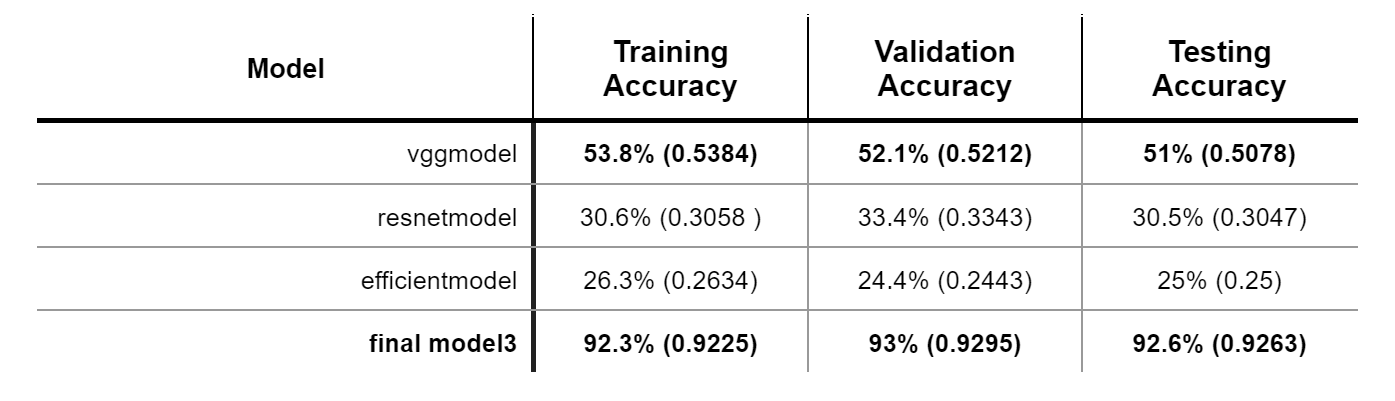

----
## **The table below shows performance data for the frozen models and the unfrozen models.**

- The **un-frozen VGG16** model demonstrated the greatest performance improvement
- The **EfficientNet** model remains unoptimized. That work is shown in another notebook in this Capstone folder.

<br>

------  

<br>

## **Key code changes to perform the analysis shown in this notebook include:**

- VGG16 expects an input shape of (224, 224, 3) while the FER 2013 dataset is 48 x 48. The data loader code resizes the FER 2013 images to 224 x 224

- 

## **Mounting the Drive**

**NOTE:** It is recommended that you use Google Colab with the GPU option selected to open and run the code in this notebook. 

In [8]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing relevant libraries**

In [9]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import keras

# Importing Deep Learning Libraries

from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from tensorflow.keras.applications.vgg16 import VGG16

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
import random

np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

### **Load the data**
A subset of the (Facial Emotion Recognition) FER 2013 which includes only these emotion classes: happy, sad, neutral, surprise

In [16]:
# Path of the data file from the Google drive

path = '/content/drive/MyDrive/Data_Science_Class/CAPSTONE_Project/CAP_proj_facial_emot_det/First-draft-w-GL-notebooks/Facial_emotion_images.zip'

# Data is provided as a zip file. The following extracts these files

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [17]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **VGG16 Model**
The VGG16 model comprises a feature-extraction section with 5 convolutional blocks (totalling **13 convolutional layers**, each with **3x3 filters**) and a classification section with three fully connected layers. **Maxpooling** is used after each of 5 convolutional blocks.

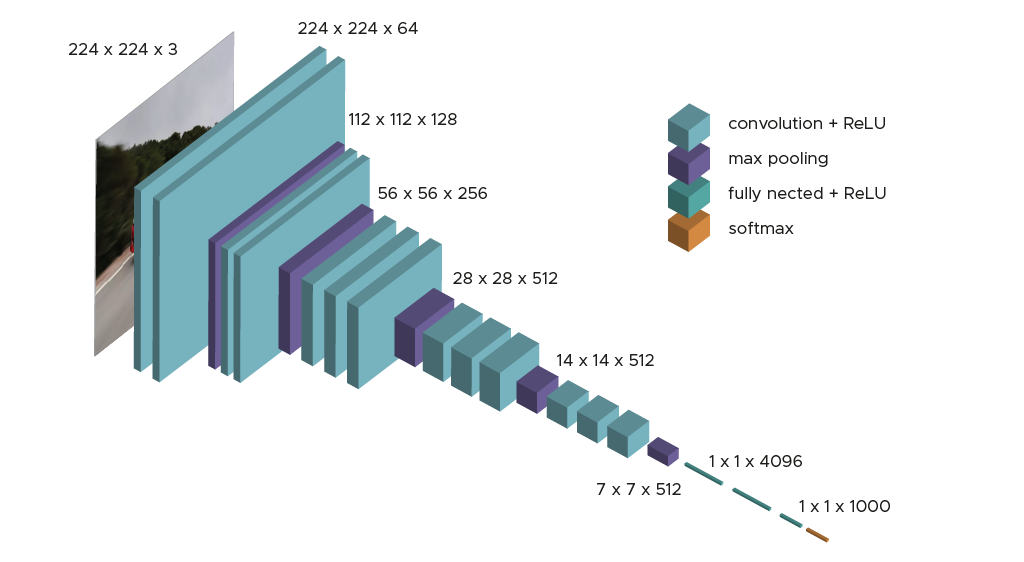

### **Importing the VGG16 Architecture**

In [18]:
# 'include_top = False' is set this way to preserve the stability provided by unchanging parameters in the Batch Normalization' layers during the UNFROZEN section in Part 2, below.


vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **Data Loaders for data augmentation and preparation for use in the Transfer Learning Architectures**

# **Base dataloader**

In [19]:
batch_size  = 32

# VGG16 expects an input_shape of 224, 224, 3
# If the model is set to False re: trainable then it can handle other shapes. If it is set to True then it MUST be set to 224, 224, 3
# https://keras.io/api/applications/vgg/

img_size = 224 

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


-------

# **Part 1: Frozen VGG16**

--------------
--------------

<br>

- The **feature extraction (VGG16)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

--------------

In [20]:
# The frozen VGG16 model is set to False so that new values are not learned in the feature extraction portion

vgg.trainable = False 

# Flattening the output from the FROZEN VGG16 model

x = Flatten()(vgg.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons with 'softmax' activation
pred = Dense(4, activation='softmax')(x)

# Initialize the model

frozen_vggmodel = Model(vgg.input, pred)

## **Setting up checkpoints**

In [21]:

checkpoint = ModelCheckpoint("./vggmodel_frozen.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

### **Compiling and Training the frozen VGG16 vggmodel**

In [22]:
# Compiling the frozen VGG16 with categorical crossentropy as the loss function, Adamax Optimizer with 0.001 learning rate, and metrics set to 'accuracy'.

frozen_vggmodel.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
                 metrics = ['accuracy'])

In [23]:
# Fitting the FROZEN VGG16 model using train_set as the training data and validation_set as the validation data, for 20 epochs.

history_vggmodel_frozen = frozen_vggmodel.fit(train_set,
                       validation_data = validation_set,
                       epochs = 20)

Epoch 1/20
473/473 [==============================] - 262s 531ms/step - loss: 1.3948 - accuracy: 0.3386 - val_loss: 1.3762 - val_accuracy: 0.3333
Epoch 2/20
473/473 [==============================] - 247s 523ms/step - loss: 1.1387 - accuracy: 0.4847 - val_loss: 1.2024 - val_accuracy: 0.4629
Epoch 3/20
473/473 [==============================] - 246s 520ms/step - loss: 1.0468 - accuracy: 0.5459 - val_loss: 0.9626 - val_accuracy: 0.5921
Epoch 4/20
473/473 [==============================] - 245s 517ms/step - loss: 1.0027 - accuracy: 0.5669 - val_loss: 0.9461 - val_accuracy: 0.5861
Epoch 5/20
473/473 [==============================] - 254s 537ms/step - loss: 0.9739 - accuracy: 0.5824 - val_loss: 0.8992 - val_accuracy: 0.6277
Epoch 6/20
473/473 [==============================] - 260s 550ms/step - loss: 0.9463 - accuracy: 0.5959 - val_loss: 0.8859 - val_accuracy: 0.6317
Epoch 7/20
473/473 [==============================] - 254s 537ms/step - loss: 0.9287 - accuracy: 0.6063 - val_loss: 0.8919 -

### **Evaluating the FROZEN VGG16 model performance on training and validation data**

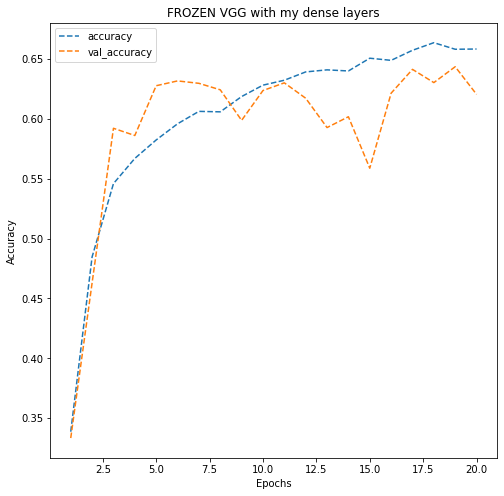

In [24]:
# Plotting the accuracy curves for the training and validation sets

dict_hist = history_vggmodel_frozen.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('FROZEN VGG with my dense layers')

plt.legend()

plt.show()

### **Evaluating the FROZEN VGG16 model performance on new TEST data**

In [25]:
# Evaluating the FROZEN vggmodel model performance on the TEST SET

frozen_vggmodel.evaluate(test_set)

4/4 [==============================] - 2s 387ms/step - loss: 0.8916 - accuracy: 0.6250


[0.8915752172470093, 0.625]

------------

# **Part 2: UN-Frozen VGG16**

--------------
--------------

<br>

- The **feature extraction (VGG16)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----

In [26]:
# In this UNFROZEN state, the weights and other parameters in the convolutional layers of the VGG16 model are allowed to change as the model is run through the FER 2013 training data

vgg.trainable = True 

# Flattening the output from the UNFROZEN VGG16 model

x = Flatten()(vgg.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons with 'softmax' activation
pred = Dense(4, activation='softmax')(x)

# Initialize the model

UN_vggmodel = Model(vgg.input, pred)

## **Setting up checkpoints**

In [27]:

UN_frozen_VGG16_checkpoint = ModelCheckpoint("./vggmodel_UNfrozen.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')


early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               ) 


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001) 


callbacks_list = [early_stopping, UN_frozen_VGG16_checkpoint, reduce_learningrate]

epochs = 20

### **Compiling and Training the UNFROZEN VGG16 Model**

In [28]:
# Compiling the UNFROZEN VGG16 with categorical crossentropy as the loss function, ADAM Optimizer with 1e-05 learning rate, and metrics set to 'accuracy'.

UN_vggmodel.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                 metrics = ['accuracy'])

In [29]:
history_vggmodel_UN = UN_vggmodel.fit(train_set,
                       validation_data = validation_set,
                       epochs = 20)

Epoch 1/20
473/473 [==============================] - 303s 626ms/step - loss: 1.2699 - accuracy: 0.4537 - val_loss: 0.9387 - val_accuracy: 0.5975
Epoch 2/20
473/473 [==============================] - 294s 622ms/step - loss: 0.9314 - accuracy: 0.6142 - val_loss: 0.8579 - val_accuracy: 0.6624
Epoch 3/20
473/473 [==============================] - 294s 621ms/step - loss: 0.8268 - accuracy: 0.6612 - val_loss: 0.7186 - val_accuracy: 0.7141
Epoch 4/20
473/473 [==============================] - 291s 616ms/step - loss: 0.7704 - accuracy: 0.6875 - val_loss: 0.7114 - val_accuracy: 0.7085
Epoch 5/20
473/473 [==============================] - 292s 617ms/step - loss: 0.7199 - accuracy: 0.7104 - val_loss: 0.6623 - val_accuracy: 0.7384
Epoch 6/20
473/473 [==============================] - 293s 619ms/step - loss: 0.6914 - accuracy: 0.7255 - val_loss: 0.6488 - val_accuracy: 0.7430
Epoch 7/20
473/473 [==============================] - 313s 662ms/step - loss: 0.6597 - accuracy: 0.7368 - val_loss: 0.6721 -

### **Evaluating the UN-FROZEN VGG16 Model performance on training and validation data**

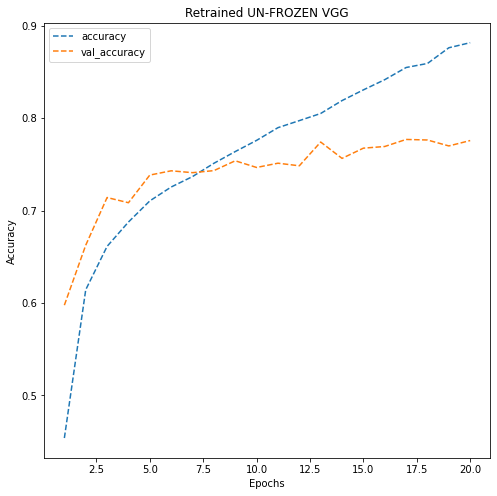

In [30]:
# Plotting the accuracy curves for the training and validation sets of the unfrozen VGG16 model

dict_hist = history_vggmodel_UN.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('Retrained UN-FROZEN VGG')

plt.legend()

plt.show()

### **Evaluating the UN-FROZEN VGG16 Model performance on new TEST data**

In [31]:
# Evaluating the UN-FROZEN VGG16 model performance on the TEST SET

UN_vggmodel.evaluate(test_set)

4/4 [==============================] - 2s 372ms/step - loss: 0.4961 - accuracy: 0.7891


[0.4961494207382202, 0.7890625]